## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
## Function to calculate the object and image points
## for camera calibration using Chessboard algorithm.
def calibrate_camera(images, output_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    # counter = 0
    for fname in images:
        #counter += 1
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '.jpg', img)
    return objpoints, imgpoints

## Function to undistort the input frames based on points calculated
## using Chessboard Corner algorithm.
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## And so on and so forth...

### Let's undistort the image from objpoints and imgpoints gathered from sample images
Refer Lesson 7: Camera Calibration

In [4]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_path = './output_images/'

In [5]:
objpoints, imgpoints = calibrate_camera(images, output_path)

In [6]:
for fname in images: 
    img = cv2.imread(fname)
    dst = cal_undistort(img, objpoints, imgpoints)
    #print(fname)
    cv2.imwrite(output_path + 'undistort/' + fname.split('/')[-1].split('.')[0] + '_undistort.jpg', dst)

In [7]:
images = glob.glob('./test_images/*.jpg')
for fname in images: 
    img = cv2.imread(fname)
    dst = cal_undistort(img, objpoints, imgpoints)
    #print(fname)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_undistort.jpg', dst)
    

### Thresholding the binary image
Refer Lesson 8: Color and Gradient

In [8]:
## Sobel Thresholding based on orientation 'x' or 'y' axis
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

## Overall magnitude of gradient using both 'x' and 'y' axis
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag / np.max(mag))
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return mag_binary

## Function to find direction of the gradient.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.abs(sobelx)
    abs_y = np.abs(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobel = np.arctan2(abs_y, abs_x)
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1 
    
    # 6) Return this mask as your binary_output image
    return dir_binary

def combined_threshold(image, ksize=3, thresh=(0,255)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

(720, 1280, 3)


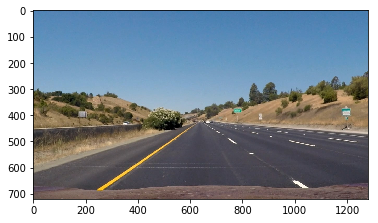

In [9]:
image = cv2.imread('./test_images/straight_lines1.jpg')
print(image.shape)

plt.imshow(image[...,::-1])

In [10]:
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

# Trials
# 200, 255 - lane in R is good
# 180, 255 - G is better in this, too much noise in B (its sky, can be cropped)
# 190, 255 - G retains the quality somewhat, can go for 180/185 as well, since
# sky will be cropped anyway.
thresh = (200, 255)

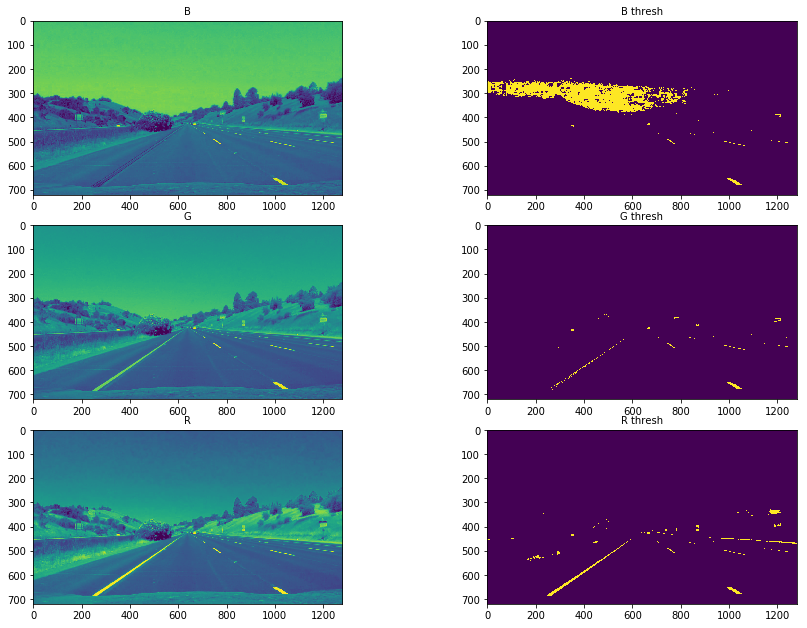

In [11]:
bin_b = np.zeros_like(b)
bin_b[(b > thresh[0]) & (b <= thresh[1])] = 1

bin_g = np.zeros_like(g)
bin_g[(g > thresh[0]) & (g <= thresh[1])] = 1

bin_r = np.zeros_like(r)
bin_r[(r > thresh[0]) & (r <= thresh[1])] = 1

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
f.tight_layout()

ax1.imshow(b)
ax1.set_title('B', fontsize=10)
ax2.imshow(bin_b)
ax2.set_title('B thresh', fontsize=10)

ax3.imshow(g)
ax3.set_title('G', fontsize=10)
ax4.imshow(bin_g)
ax4.set_title('G thresh', fontsize=10)

ax5.imshow(r)
ax5.set_title('R', fontsize=10)
ax6.imshow(bin_r)
ax6.set_title('R thresh', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

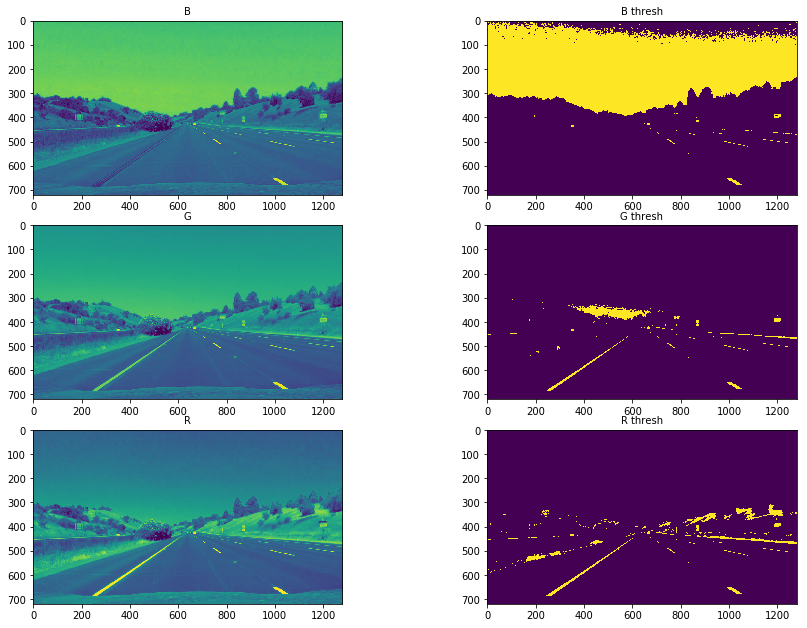

In [12]:
thresh = (180, 255)

bin_b = np.zeros_like(b)
bin_b[(b > thresh[0]) & (b <= thresh[1])] = 1

bin_g = np.zeros_like(g)
bin_g[(g > thresh[0]) & (g <= thresh[1])] = 1

bin_r = np.zeros_like(r)
bin_r[(r > thresh[0]) & (r <= thresh[1])] = 1

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
f.tight_layout()

ax1.imshow(b)
ax1.set_title('B', fontsize=10)
ax2.imshow(bin_b)
ax2.set_title('B thresh', fontsize=10)

ax3.imshow(g)
ax3.set_title('G', fontsize=10)
ax4.imshow(bin_g)
ax4.set_title('G thresh', fontsize=10)

ax5.imshow(r)
ax5.set_title('R', fontsize=10)
ax6.imshow(bin_r)
ax6.set_title('R thresh', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

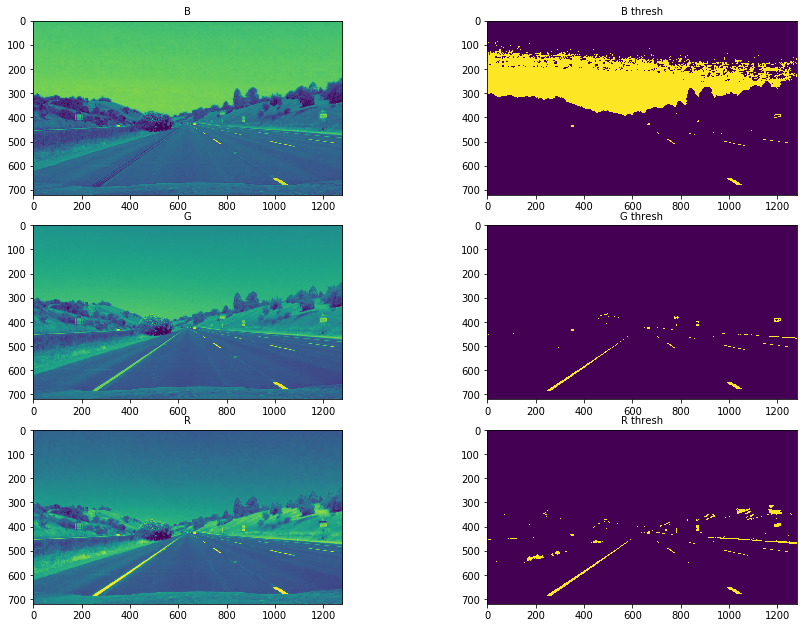

In [13]:
thresh = (190, 255)

bin_b = np.zeros_like(b)
bin_b[(b > thresh[0]) & (b <= thresh[1])] = 1

bin_g = np.zeros_like(g)
bin_g[(g > thresh[0]) & (g <= thresh[1])] = 1

bin_r = np.zeros_like(r)
bin_r[(r > thresh[0]) & (r <= thresh[1])] = 1

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
f.tight_layout()

ax1.imshow(b)
ax1.set_title('B', fontsize=10)
ax2.imshow(bin_b)
ax2.set_title('B thresh', fontsize=10)

ax3.imshow(g)
ax3.set_title('G', fontsize=10)
ax4.imshow(bin_g)
ax4.set_title('G thresh', fontsize=10)

ax5.imshow(r)
ax5.set_title('R', fontsize=10)
ax6.imshow(bin_r)
ax6.set_title('R thresh', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
## ksize 7,11,15 look good.

im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [15]:
# ksize = 3
# thresh=(20, 255)

# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
# f.tight_layout()

# ax1.imshow(gradx)
# ax1.set_title('Grad X', fontsize=10)

# ax2.imshow(grady)
# ax2.set_title('Grad Y', fontsize=10)

# ax3.imshow(mag_binary)
# ax3.set_title('Mag Gradient', fontsize=10)

# ax4.imshow(dir_binary)
# ax4.set_title('Direction Gradient', fontsize=10)

In [16]:
# ksize = 5
# thresh=(40, 255)

# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
# f.tight_layout()

# ax1.imshow(gradx)
# ax1.set_title('Grad X', fontsize=10)

# ax2.imshow(grady)
# ax2.set_title('Grad Y', fontsize=10)

# ax3.imshow(mag_binary)
# ax3.set_title('Mag Gradient', fontsize=10)

# ax4.imshow(dir_binary)
# ax4.set_title('Direction Gradient', fontsize=10)

Text(0.5,1,'Direction Gradient')

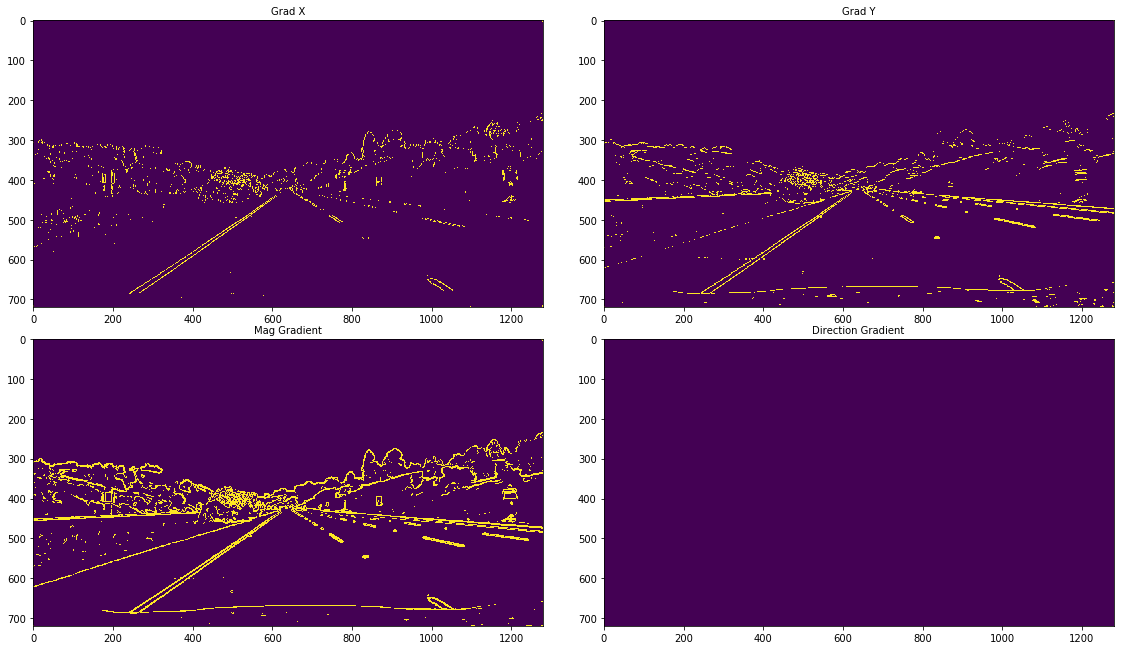

In [17]:
ksize = 7
thresh=(40, 255)

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()

ax1.imshow(gradx)
ax1.set_title('Grad X', fontsize=10)

ax2.imshow(grady)
ax2.set_title('Grad Y', fontsize=10)

ax3.imshow(mag_binary)
ax3.set_title('Mag Gradient', fontsize=10)

ax4.imshow(dir_binary)
ax4.set_title('Direction Gradient', fontsize=10)

In [18]:
# ksize = 9
# thresh=(20, 255)

# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
# f.tight_layout()

# ax1.imshow(gradx)
# ax1.set_title('Grad X', fontsize=10)

# ax2.imshow(grady)
# ax2.set_title('Grad Y', fontsize=10)

# ax3.imshow(mag_binary)
# ax3.set_title('Mag Gradient', fontsize=10)

# ax4.imshow(dir_binary)
# ax4.set_title('Direction Gradient', fontsize=10)

Text(0.5,1,'Direction Gradient')

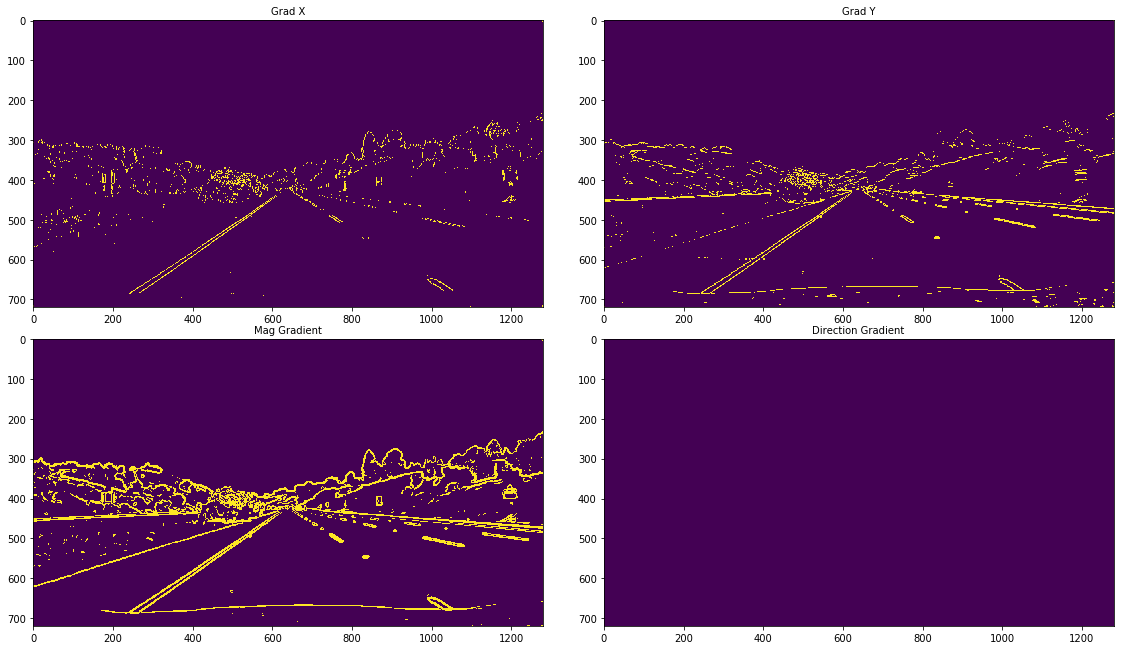

In [19]:
ksize = 11
thresh=(40, 255)

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()

ax1.imshow(gradx)
ax1.set_title('Grad X', fontsize=10)

ax2.imshow(grady)
ax2.set_title('Grad Y', fontsize=10)

ax3.imshow(mag_binary)
ax3.set_title('Mag Gradient', fontsize=10)

ax4.imshow(dir_binary)
ax4.set_title('Direction Gradient', fontsize=10)

Text(0.5,1,'Direction Gradient')

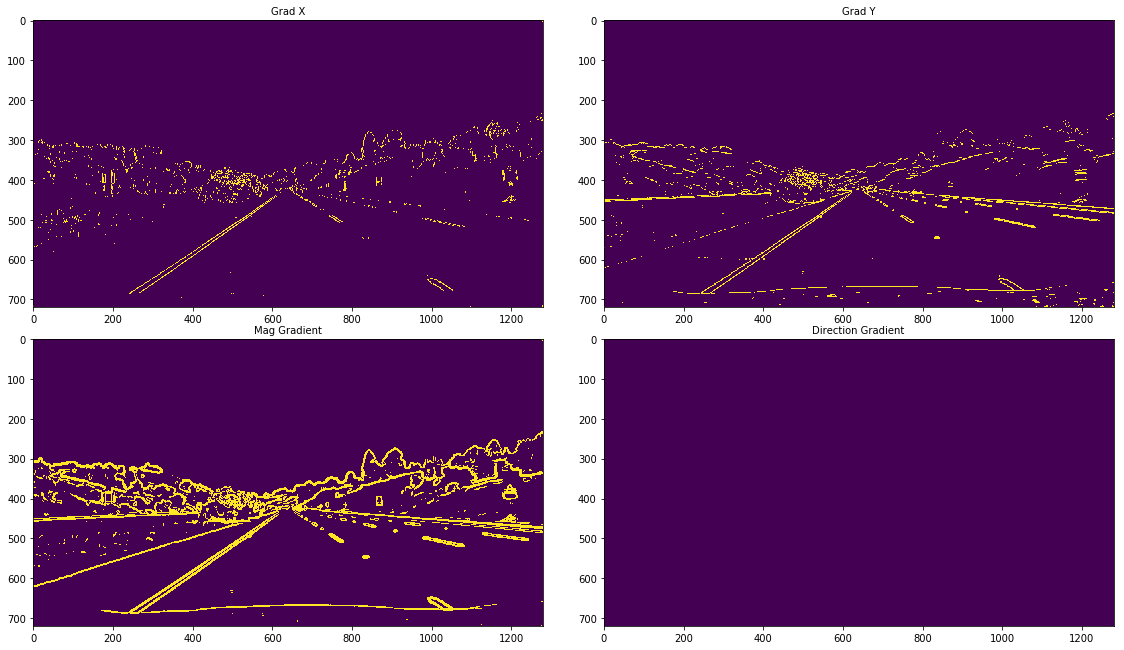

In [20]:
ksize = 15
thresh=(40, 255)

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresh)
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()

ax1.imshow(gradx)
ax1.set_title('Grad X', fontsize=10)

ax2.imshow(grady)
ax2.set_title('Grad Y', fontsize=10)

ax3.imshow(mag_binary)
ax3.set_title('Mag Gradient', fontsize=10)

ax4.imshow(dir_binary)
ax4.set_title('Direction Gradient', fontsize=10)

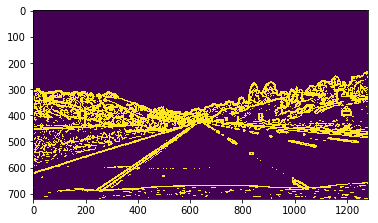

In [21]:
combined = combined_threshold(image, ksize, thresh=(20, 255))

plt.imshow(combined)

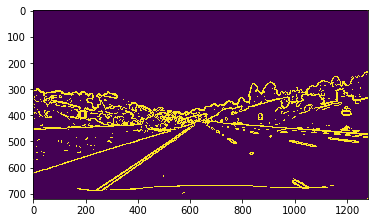

In [22]:
combined = combined_threshold(image, ksize, thresh=(40, 255))

plt.imshow(combined)

### Use HLS for color thresholding

In [23]:
## Function to return HLS components of image
def get_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,0], hls[:,:,1], hls[:,:,2]

In [24]:
h, l, s = get_hls(image)

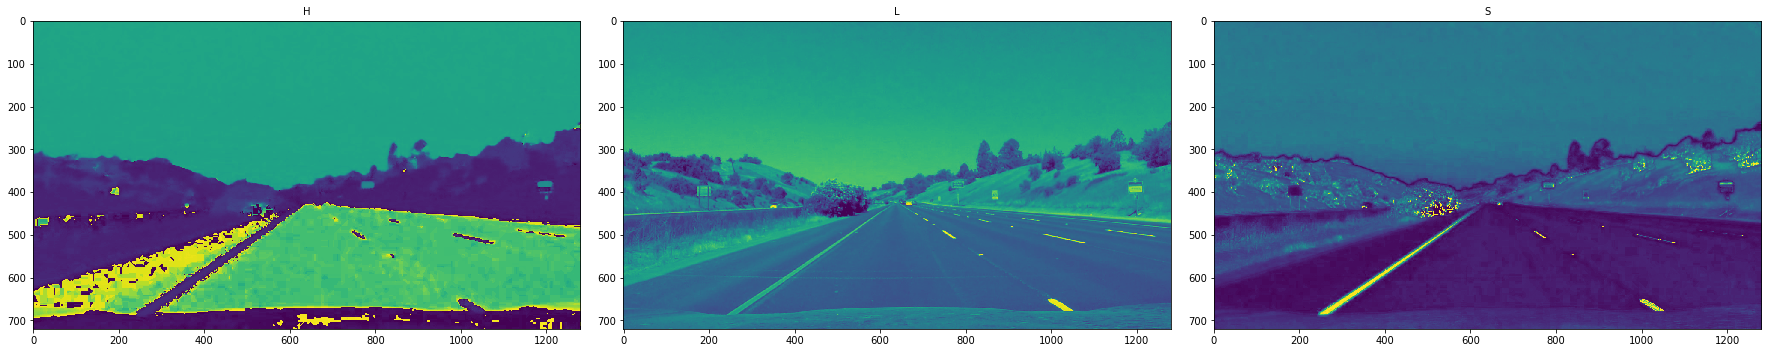

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h)
ax1.set_title('H', fontsize=10)
ax2.imshow(l)
ax2.set_title('L', fontsize=10)
ax3.imshow(s)
ax3.set_title('S', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Let's see what thresholding HLS gives us.

Thresholding Candidates till now:<br/> 
R - (190, 255)<br/> 
Mag Gradient - (ksize = 11, thresh=(40, 255))

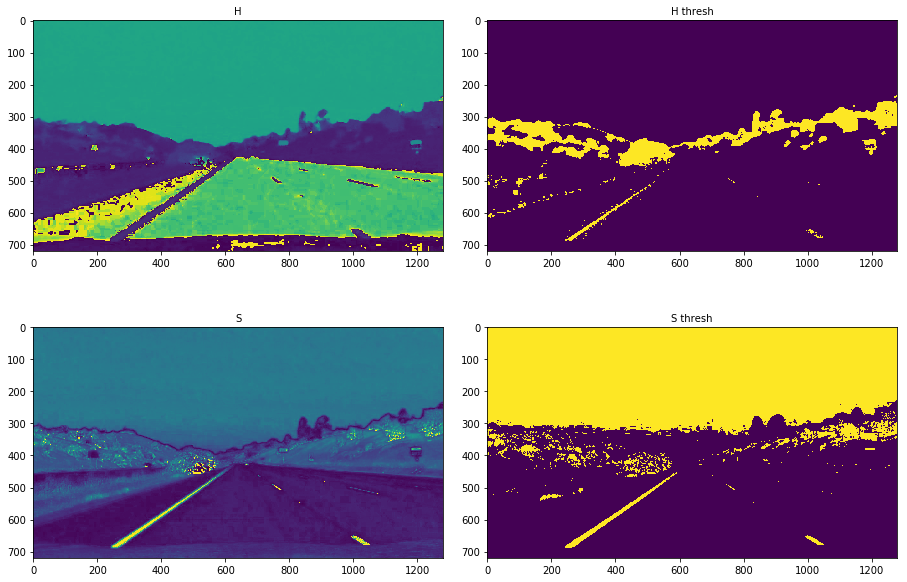

In [26]:
thresh = (90, 255)

bin_h = np.zeros_like(h)
bin_h[(h > 20) & (h <= 90)] = 1

# bin_l = np.zeros_like(l)
# bin_l[(l > thresh[0]) & (l <= thresh[1])] = 1

bin_s = np.zeros_like(s)
bin_s[(s > thresh[0]) & (s <= thresh[1])] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
f.tight_layout()

ax1.imshow(h)
ax1.set_title('H', fontsize=10)
ax2.imshow(bin_h)
ax2.set_title('H thresh', fontsize=10)

ax3.imshow(s)
ax3.set_title('S', fontsize=10)
ax4.imshow(bin_s)
ax4.set_title('S thresh', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### R and S channel detect lanes in different scenarios well. Let's try combining both to threshold and detect the lanes!

Thresholding Candidates till now:<br/> 
R - (190, 255)<br/> 
Mag Gradient - (ksize = 11, thresh=(40, 255))<br/> 
S - (90, 255)

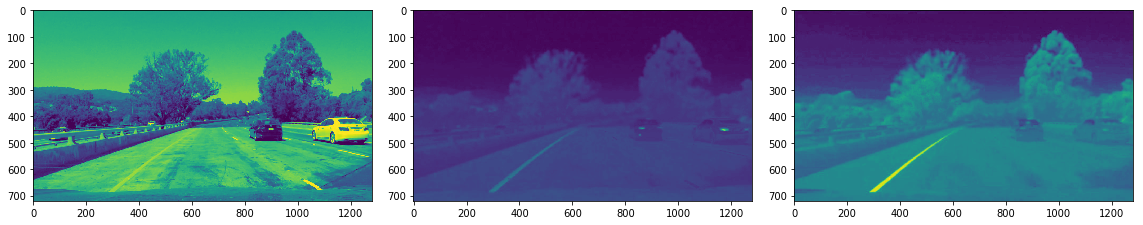

In [27]:
image = cv2.imread('./test_images/test1.jpg')

l = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]
u = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,1]
v = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
f.tight_layout()

ax1.imshow(l)
ax2.imshow(u)
ax3.imshow(v)

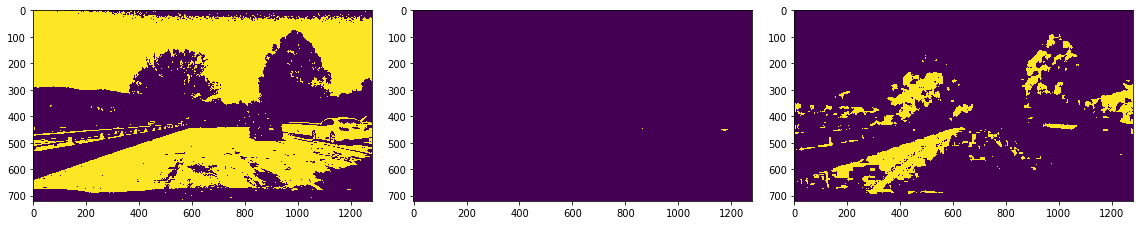

In [28]:
bin_l = np.zeros_like(l)
bin_l[(l > 150) & (l <= 255)] = 1

bin_u = np.zeros_like(u)
bin_u[(u > 150) & (u <= 255)] = 1

bin_v = np.zeros_like(v)
bin_v[(v > 150) & (v <= 255)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
f.tight_layout()

ax1.imshow(bin_l)
ax2.imshow(bin_u)
ax3.imshow(bin_v)

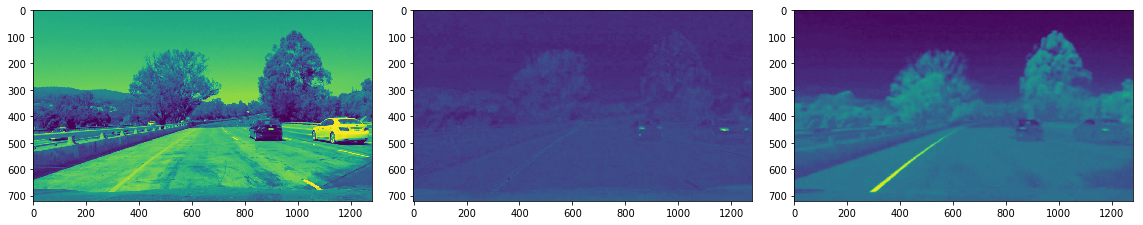

In [29]:
image = cv2.imread('./test_images/test1.jpg')

## Reference: https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab
l = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,0]
a = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,1]
b = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
f.tight_layout()

ax1.imshow(l)
ax2.imshow(a)
ax3.imshow(b)

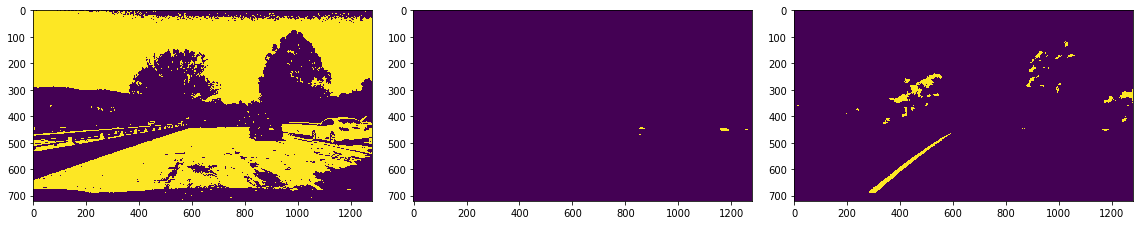

In [30]:
bin_l = np.zeros_like(l)
bin_l[(l > 150) & (l <= 255)] = 1

bin_a = np.zeros_like(a)
bin_a[(a > 150) & (a <= 255)] = 1

bin_b = np.zeros_like(b)
bin_b[(b > 150) & (b <= 255)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
f.tight_layout()

ax1.imshow(bin_l)
ax2.imshow(bin_a)
ax3.imshow(bin_b)

## Next is perspective transform

src = {<br/> 
Top Left - 620, 435<br/> 
Top Right - 655, 435<br/> 
Bottom Right - 1045, 690<br/> 
Bottom Left - 255, 690<br/> 
}

dest = {<br/> 
280 - 1000<br/> 
Top Left - 280, 435<br/> 
Top Right - 1000, 435<br/> 
Bottom Right - 1000, 690<br/> 
Bottom Left - 280, 690<br/> 
}

In [31]:
def image_warp(image):
    
    img_size = (image.shape[1], image.shape[0])

    ## Reference: https://yangcha.github.io/iview/iview.html
    ## If we take points till farthest visible lane, it won't work
    ## correctly for curves and difficult lanes.
    ## Since it is in moving vehicle and video will be processed
    ## frame by frame, better to consider the point ahead
    ## until where the lanes are clear.
    ## Lanes are approx 200px apart at the farthest clear
    ## straight line.
    src = np.float32([
        [490, 480],
        [810, 480],
        [1250, 720],
        [40, 720]
    ])
    dst = np.float32([
        [0, 0],
        [1280, 0],
        [1250, 720],
        [40, 720]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(cal_undistort(image, objpoints, imgpoints), M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

In [32]:
# def custom_thresh(image, ksize=11, r_thresh=(190, 255), m_thresh=(40, 255), s_thresh=(90, 255)):
def custom_thresh(image, ksize=11, r_thresh=(190, 255), m_thresh=(40, 255), \
                  s_thresh=(90, 255), b_thresh=(155, 255)):
    img, M = image_warp(image)

    ## Red Threshold is not working when shadows are on the road. Too much noise is being detected
    ## Need to find a better way
#     r = image[:,:,2]
#     mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=m_thresh)

    s = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    bin_s = np.zeros_like(s)
    bin_s[(s > s_thresh[0]) & (s <= s_thresh[1])] = 1
    
#     bin_r = np.zeros_like(r)
#     bin_r[(r > r_thresh[0]) & (r <= r_thresh[1])] = 1
#     combined = np.zeros_like(r)
#     combined[(bin_r == 1) | (mag_binary == 1) | (bin_s == 1)] = 1
# #     color_binary = np.dstack(( np.zeros_like(mag_binary), bin_s, bin_r)) * 255
#     return combined

    ## Reference: https://medium.com/@ajsmilutin/advanced-lane-finding-5d0be4072514
    b = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
#     plt.imshow(b)

    bin_b = np.zeros_like(b)
    bin_b[(b >= b_thresh[0]) & (b <= b_thresh[1])] = 1
    
    combined = np.zeros_like(bin_s)
    combined[(bin_s == 1) | (bin_b == 1)] = 1
    
    return combined

In [33]:
combined = custom_thresh(image)
# plt.imshow(combined)

In [34]:
image = cv2.imread('./test_images/straight_lines1.jpg')

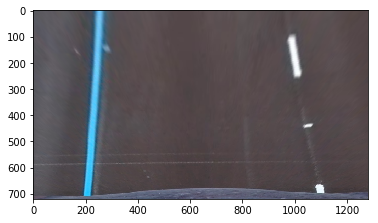

In [35]:
warped, M = image_warp(image)

plt.imshow(warped)

In [36]:
## Reference for testing: https://knowledge.udacity.com/questions/30221

img_size = (image.shape[1], image.shape[0])
src = np.float32( [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100], [((img_size[0] / 6) - 10), img_size[1]], [(img_size[0] * 5 / 6) + 60, img_size[1]], [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 
dst = np.float32( [[(img_size[0] / 4), 0], [(img_size[0] / 4), img_size[1]], [(img_size[0] * 3 / 4), img_size[1]], [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(cal_undistort(image[...,::-1], objpoints, imgpoints), M, img_size, flags=cv2.INTER_LINEAR)

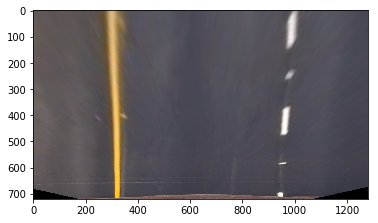

In [37]:
plt.imshow(warped)

## It's time to detect those lanes!

In [38]:
def hist(img):
    img = custom_thresh(img)
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

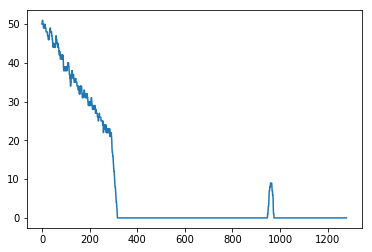

In [39]:
histogram = hist(warped)

plt.plot(histogram)

In [40]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        left_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        right_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        good_left_inds = left_ind
        good_right_inds = right_ind
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        #pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    plt.imshow(out_img)

    ### Fit a second order polynomial to each using `np.polyfit` ###
#     print(lefty, leftx)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 30

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] - margin) & 
        (nonzerox < left_fit[0]*nonzeroy**2 + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))
    right_lane_inds = ((nonzerox > right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] - margin) & 
        (nonzerox < right_fit[0]*nonzeroy**2 + 
        right_fit[1]*nonzeroy + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
#     print(leftx, lefty)

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

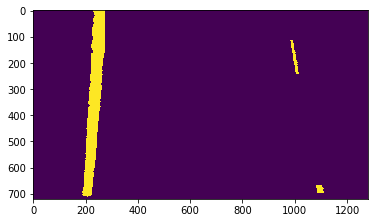

In [41]:
binary_warped = custom_thresh(image)
plt.imshow(binary_warped)

In [42]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
binary_warped=binary

[640 640 640 ...,  79  79  79] [311 312 313 ..., 352 353 354]


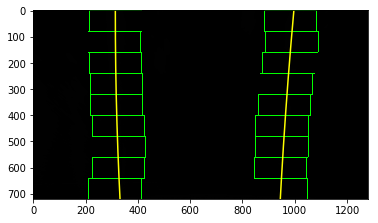

In [43]:
out_img, left_fit, right_fit = fit_polynomial(binary_warped)

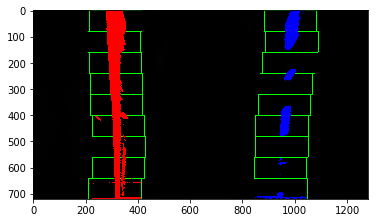

In [44]:
plt.imshow(out_img)

In [45]:
print(left_fit)
print(right_fit)

[  3.62874201e-05  -1.29848176e-03   3.14023568e+02]
[  2.52777096e-05  -9.00627471e-02   9.96486440e+02]


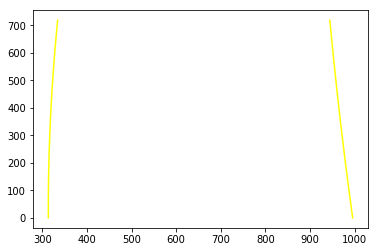

In [46]:
result = search_around_poly(binary_warped)

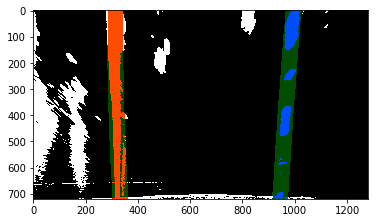

In [47]:
plt.imshow(result)

## Pipeline in short till now

In [48]:
def get_lanes(image, enable_r=True):
    binary_warped = custom_thresh(image)
    result = search_around_poly(binary_warped)
    return result

#     if enable_r:
#         r_s_thresh = custom_thresh(image, r_thresh=(0,0))
#     else:
#         r_s_thresh = custom_thresh(image)
#     thresh = (30, 255)
#     gray = r_s_thresh#cv2.cvtColor(r_s_thresh, cv2.COLOR_BGR2GRAY)
#     binary = np.zeros_like(gray)
#     binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
#     binary_warped, M = image_warp(binary)
#     plt.imshow(binary_warped)
#     print(binary_warped)
#     result = fit_polynomial(binary_warped)    

In [49]:
image = cv2.imread('./test_images/straight_lines2.jpg')

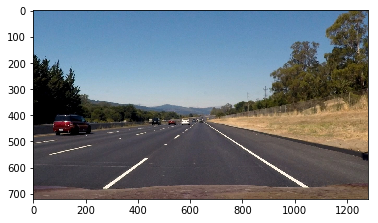

In [50]:
plt.imshow(image[...,::-1])

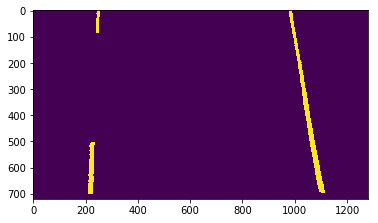

In [51]:
binary_warped = custom_thresh(image)
plt.imshow(binary_warped)

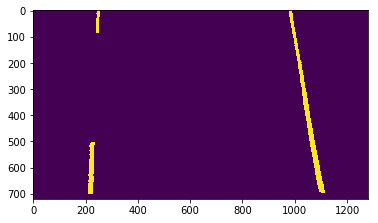

In [52]:
# gray = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)

binary = np.zeros_like(binary_warped)
binary[(binary_warped > 0) & (binary_warped <= 255)] = 1

plt.imshow(binary)

In [53]:
# lane = get_lanes(image)

In [54]:
# lane = search_around_poly(lane)
# plt.imshow(lane)

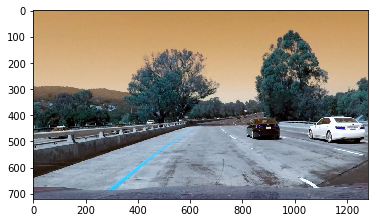

In [55]:
image = cv2.imread('./test_images/test1.jpg')
plt.imshow(image)

In [56]:
# lane = get_lanes(image)
# plt.imshow(lane)

In [57]:
def get_lanes(image):
    binary_warped = custom_thresh(image)

    warped = binary_warped

    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows     
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

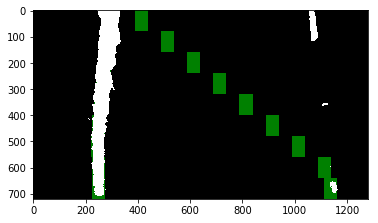

In [58]:
output = get_lanes(image)
plt.imshow(output)

### Currect Pipeline with windowing

In [59]:
# def measure_curvature_pixels():
#     '''
#     Calculates the curvature of polynomial functions in pixels.
#     '''
#     # Start by generating our fake example data
#     # Make sure to feed in your real data instead in your project!
#     ploty, left_fit, right_fit = generate_data()
    
#     # Define y-value where we want radius of curvature
#     # We'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
    
#     ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
#     ## R = ((1+(2Ay+B)^2)^3/2)/2A
#     left_curverad = ((1 + (2 * left_fit[0]*y_eval + left_fit[1])**2)**(3/2)) / np.abs(2 * left_fit[0])
#     #left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     #0  ## Implement the calculation of the left line here
#     right_curverad = ((1 + (2 * right_fit[0]*y_eval + right_fit[1])**2)**(3/2)) / np.abs(2 * right_fit[0])
#     #right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
#     #0  ## Implement the calculation of the right line here
    
#     return left_curverad, right_curverad


# # Calculate the radius of curvature in pixels for both lane lines
# left_curverad, right_curverad = measure_curvature_pixels()

# print(left_curverad, right_curverad)

In [73]:
def draw_lanes(image):
    binary_warped = custom_thresh(image)
    
    ## Lane positions in the image
    leftx, lefty, rightx, righty = [], [], [], []
    
    # Take a histogram of the bottom half of the image
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    ## Initial point of Left and Right Lane.
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of sliding windows
    nwindows = 9
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Width of the windows +/- margin
    margin = 50
    # Minimum number of pixels found to recenter window
    minpix = 30
        
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions of Left and Right Lane.
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        histogram = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
        leftx_current = np.argmax(histogram[:midpoint])
        rightx_current = np.argmax(histogram[midpoint:]) + midpoint

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        left_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        right_ind = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
            (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        good_left_inds = left_ind
        good_right_inds = right_ind
        
        # Append these indices to the lists
        if (np.sum(good_left_inds) != 0):
            leftx.extend(nonzerox[left_ind].tolist())
            lefty.extend(nonzeroy[left_ind].tolist())
        if (np.sum(good_right_inds) != 0):
            rightx.extend(nonzerox[right_ind].tolist())
            righty.extend(nonzeroy[right_ind].tolist())

    leftx = np.float32(np.array(leftx))
    lefty = np.float32(np.array(lefty))
    rightx = np.float32(np.array(rightx))
    righty = np.float32(np.array(righty))
    
    flag = 0
    ### Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except Exception:
        flag = 1

    if flag == 0:
        ## Ax2 + Bx + C
        try:
            left_fitx = (left_fit[0]*lefty)**2 + left_fit[1]*lefty + left_fit[2]
            right_fitx = (right_fit[0]*righty)**2 + right_fit[1]*righty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = (1*ploty)**2 + 1*ploty
            right_fitx = (1*ploty)**2 + 1*ploty

        ## For the bottom of the image
        left_bottom = (left_fit[0]*binary_warped.shape[0])**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
        right_bottom = (right_fit[0]*binary_warped.shape[0])**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]

        leftx = np.append(leftx, left_bottom)
        lefty = np.append(lefty, binary_warped.shape[0])
        rightx = np.append(rightx, right_bottom)
        righty = np.append(righty, binary_warped.shape[0])

        ## For the top of the image
        left_top = (left_fit[0]*0)**2 + left_fit[1]*0 + left_fit[2]
        right_top = (right_fit[0]*0)**2 + right_fit[1]*binary.shape[0] + right_fit[2]

        leftx = np.append(leftx, left_top)
        lefty = np.append(lefty, 0)
        rightx = np.append(rightx, right_top)
        righty = np.append(righty, 0)

        lsort = np.argsort(lefty)
        rsort = np.argsort(righty)

        lefty = lefty[lsort]
        leftx = leftx[lsort]
        righty = righty[rsort]
        rightx = rightx[rsort]

        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = (left_fit[0]*lefty)**2 + left_fit[1]*lefty + left_fit[2]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = (right_fit[0]*righty)**2 + right_fit[1]*righty + right_fit[2]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        ##### Calculation of R_curve (radius of curvature) #####
        left_curverad = ((1 + ((2*left_fit_cr[0]*np.max(lefty)) \
                               + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])
        right_curverad = ((1 + ((2*right_fit_cr[0]*np.max(righty)) \
                                + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])

        img_size = (image.shape[1], image.shape[0])
        src = np.float32([
            [490, 480],
            [810, 480],
            [1250, 720],
            [40, 720]
        ])
        dst = np.float32([
            [0, 0],
            [1280, 0],
            [1250, 720],
            [40, 720]
        ])

        ## Map warped points back to Real image
        Minv = cv2.getPerspectiveTransform(dst, src)

        ## Visualization ##
        warp = np.uint8(np.zeros_like(binary_warped))
        color_out = np.dstack((warp, warp, warp))

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_lane = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
        right_lane = np.array([np.transpose(np.vstack([right_fitx, righty]))])

        lanes = np.hstack((left_lane, right_lane))

        cv2.polylines(color_out, np.int_([lanes]), isClosed=False, color=(0,0,255), thickness = 40)
        cv2.fillPoly(color_out, np.int_([lanes]), (0,255, 0))

        real_image = cv2.warpPerspective(color_out, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
        result = cv2.addWeighted(image, 1, real_image, 0.3, 0)

    #     plt.imshow(result)
    #     ## Reference: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.text.html#matplotlib.pyplot.text
    #     plt.text(100, 80, 'Radius of Curvature is {}m'.format(int(left_curverad + right_curverad)/2),\
    #             fontsize=14)

        ## Reference: https://stackoverflow.com/a/34273603
        cv2.putText(
            result, 
            'Radius of Curvature is {}m'.format(int(left_curverad + right_curverad)/2), 
            (100, 80), 
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5, 
            (0, 0, 0),
            3,
            lineType=cv2.LINE_AA
        )
        # Calculate the position of the vehicle
        # How much is it away from the center.
        # Assumption: Camera is mounted on the center of the vehicle
        center = abs(midpoint - ((right_bottom+left_bottom)/2))
        if center < midpoint:
            cv2.putText(
                result, 
                'The vehicle is {:.2f}m towards left'.format(center*xm_per_pix), 
                (100, 130), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1.5, 
                (0, 0, 0),
                3,
                lineType=cv2.LINE_AA
            )
        else:
            cv2.putText(
                result, 
                'The vehicle is {:.2f}m towards right'.format(center*xm_per_pix), 
                (100, 130), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1.5, 
                (0, 0, 0),
                3,
                lineType=cv2.LINE_AA
            )
    else:
        result = image
 
    return result

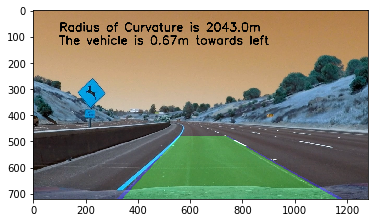

In [61]:
image = cv2.imread('./test_images/test2.jpg')
plt.imshow(draw_lanes(image))

In [62]:
# image = cv2.imread('./test_images/test2.jpg')
# draw_lanes(image)

In [63]:
# image = cv2.imread('./test_images/test2.jpg')
# draw_lanes(image)

In [64]:
for image in glob.glob('test_images/test*.jpg'):
    draw_lanes(cv2.imread(image))

## Time for Video pipeline!!!

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
video_output = './output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4").subclip(0,15)
white_clip = clip1.fl_image(draw_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 375/376 [04:51<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 4min 15s, sys: 892 ms, total: 4min 15s
Wall time: 4min 54s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [80]:
video_output = './output_videos/project_video_full.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")#.subclip(0,15)
white_clip = clip1.fl_image(draw_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_full.mp4
[MoviePy] Writing video ./output_videos/project_video_full.mp4



100%|█████████▉| 1260/1261 [16:55<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_full.mp4 

CPU times: user 14min 39s, sys: 3.49 s, total: 14min 42s
Wall time: 16min 58s


In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [75]:
video_output = './output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./challenge_video.mp4")#.subclip(0,15)
white_clip = clip1.fl_image(draw_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4



 32%|███▏      | 155/485 [01:18<03:26,  1.60it/s]


 64%|██████▎   | 309/485 [02:38<01:29,  1.97it/s]


 95%|█████████▌| 463/485 [04:00<00:12,  1.72it/s]


100%|██████████| 485/485 [04:12<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

CPU times: user 3min 24s, sys: 486 ms, total: 3min 24s
Wall time: 4min 15s


In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[640 640 640 ...,  79  79  79] [230 231 232 ..., 327 328 329]
[640 640 640 ...,  79  79  79] [195 196 197 ..., 274 275 276]
[640 640 640 ...,  79  79  79] [246 247 248 ..., 382 383 384]
[640 640 640 ...,  79  79  79] [275 276 277 ..., 298 299 300]
[640 640 640 ...,  79  79  79] [224 225 226 ..., 362 363 364]
[640 640 640 ...,  79  79  79] [154 155 156 ..., 303 304 305]
[640 640 640 ...,  79  79  79] [213 214 215 ..., 248 249 250]
[640 640 640 ...,  79  79  79] [172 173 174 ..., 336 337 338]


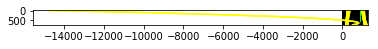

In [79]:
images = glob.glob('./test_images/*.jpg')
for fname in images: 
    img = cv2.imread(fname)
    dst = cal_undistort(img, objpoints, imgpoints)

    ksize = 15
    thresh=(40, 255)

    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=thresh)
    
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_gradient_x.jpg', gradx)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_gradient_y.jpg', grady)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_mag_gradient.jpg', mag_binary)
    
    warped, M = image_warp(img)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_perspective_trasformed.jpg', warped)
    
    binary_warped = custom_thresh(img)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_threshold.jpg', binary_warped)
    
    out_img, left_fit, right_fit = fit_polynomial(binary_warped)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_lane_window.jpg', out_img)
    
    result = search_around_poly(binary_warped)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_lane_roi.jpg', result)
    
    final = draw_lanes(img)
    cv2.imwrite(output_path + fname.split('/')[-1].split('.')[0] + '_lane_final.jpg', final)